# Rice Image Classification
Ilan Sirisky 207810458

Eldad Tsemach 209161447

In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('./Rice_Image_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

./Rice_Image_Dataset\Arborio\Arborio (1).jpg
./Rice_Image_Dataset\Basmati\Basmati (1).jpg
./Rice_Image_Dataset\Ipsala\Ipsala (1).jpg
./Rice_Image_Dataset\Jasmine\Jasmine (1).jpg
./Rice_Image_Dataset\Karacadag\Karacadag (1).jpg


In [77]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as ski

import glob
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics

import pprint

## **In this notebook we will use Image Processing techniques to create features for classifying rice images.**



**Contents:**

**1. Exploratory Data Analysis**

**2. Preprocessing Images**

**3. Feature explanation**

**4. Get Image features**

**5. Train multiple classifiers and evaluate.**

**6. Identify important features.**


## 1 Exploratory Data Analysis

In [30]:
NUM_CLASSES = 5

In [31]:
class_folders = [
    "./Rice_Image_Dataset/Karacadag",
    "./Rice_Image_Dataset/Basmati",
    "./Rice_Image_Dataset/Jasmine",
    "./Rice_Image_Dataset/Arborio",
    "./Rice_Image_Dataset/Ipsala"
]

**We can see that, the rice grain images have somewhat similar color and rice grains of different types differ mostly on the basis of the shape and size.**

**We can use image processing techniques to create features based on the size/shape of the rice grain images and then use them for classsification.**

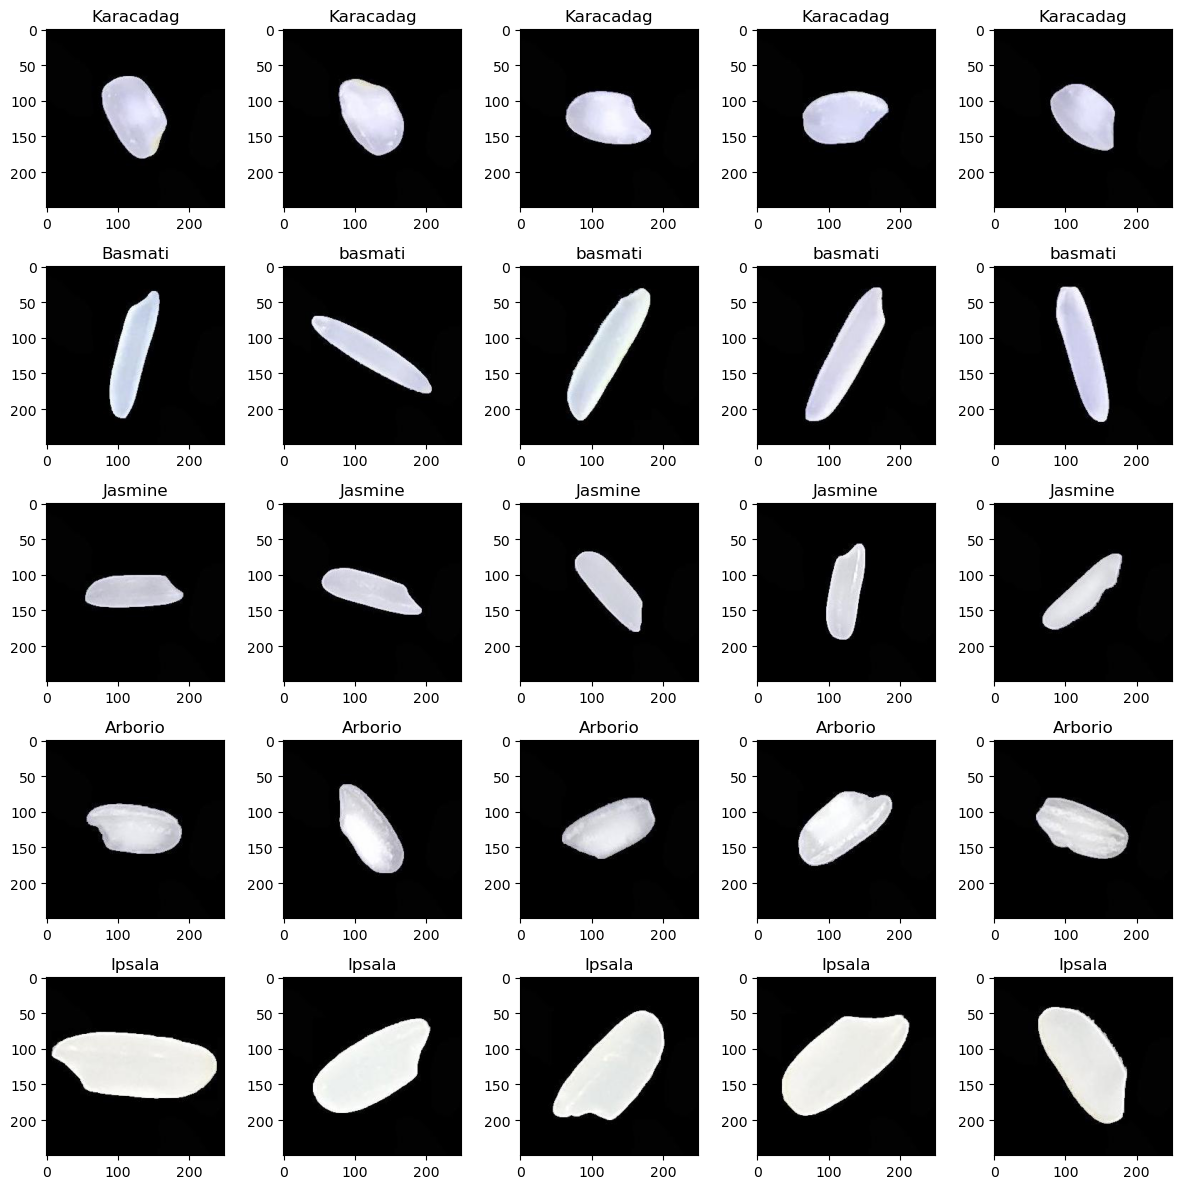

In [36]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
for i, folder in enumerate(class_folders):
    for j, filename in enumerate(glob.glob(folder + "/*.jpg")[:5]):
        img = ski.io.imread(filename)
        axs[i,j].imshow(img)
        axs[i,j].set_title(filename.split("\\")[-1].split()[0])
plt.tight_layout();

## 2 Image Processing

1. Convert to grayscale.
2. Threshold the image to get a binary map and trace contours of the rice grain.
3. Use contours to create features like length, size, shape etc.

We are going to use contours to calculate contour based features for our object of interest (rice grain).


In [37]:
# Sample image files for testing our transformations

num_sample_images = 1
image_dict = {}
for i, folder in enumerate(class_folders):
    image_dict[folder.split("\\")[-1].split()[0]] = glob.glob(folder + "/*.jpg")[:num_sample_images]

pprint.pprint(image_dict)

{'./Rice_Image_Dataset/Arborio': ['./Rice_Image_Dataset/Arborio\\Arborio '
                                  '(1).jpg'],
 './Rice_Image_Dataset/Basmati': ['./Rice_Image_Dataset/Basmati\\Basmati '
                                  '(1).jpg'],
 './Rice_Image_Dataset/Ipsala': ['./Rice_Image_Dataset/Ipsala\\Ipsala (1).jpg'],
 './Rice_Image_Dataset/Jasmine': ['./Rice_Image_Dataset/Jasmine\\Jasmine '
                                  '(1).jpg'],
 './Rice_Image_Dataset/Karacadag': ['./Rice_Image_Dataset/Karacadag\\Karacadag '
                                    '(1).jpg']}


In [38]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def threshold_image(img, thresh_min=155, thresh_max=255):
    return cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]

def getContours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return (contours, hierarchy)

def drawContours(image, contours):
    return cv2.drawContours(image, contours, -1, (255, 0, 0), 0)

def calculateImageFeatures(contours, featcols):
    feat_array = np.zeros((1, len(featcols)), np.float32)
    mmnts =  cv2.moments(contours[0], False)
    for i, k in enumerate(sorted(mmnts.keys())):
        feat_array[0, i] = mmnts[k]
    
    area = cv2.contourArea(contours[0], False)
    
    centroid_x = mmnts['m10']/(mmnts['m00'] + 0.000000000001)
    centroid_y = mmnts['m01']/(mmnts['m00'] + + 0.000000000001)
    arcLength = cv2.arcLength(contours[0], True)
    
    feat_array[0, len(mmnts)] = area
    feat_array[0, len(mmnts)+1] = centroid_x
    feat_array[0, len(mmnts)+2] = centroid_y
    feat_array[0, len(mmnts)+3] = arcLength
    
    return feat_array

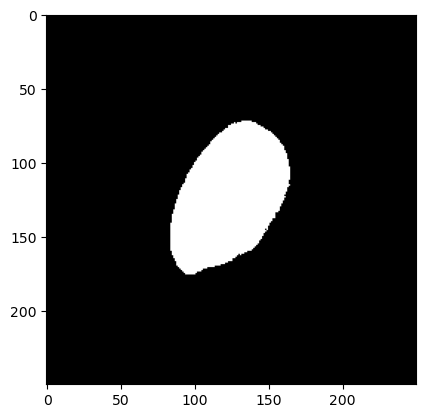

In [39]:
sample_thresh = threshold_image(to_grayscale(cv2.imread("./Rice_Image_Dataset/Karacadag/Karacadag (11154).jpg")))
plt.imshow(sample_thresh, cmap='gray');

In [40]:
cnts, h = getContours(sample_thresh)
sample_moments = cv2.moments(cnts[0], False)

feature_cols = list(sorted(sample_moments.keys())) + ["area", "centroidx", "centroidy", "length"]
pprint.pprint(feature_cols)

sample_features = calculateImageFeatures(cnts, feature_cols)
pprint.pprint(sample_features)

['m00',
 'm01',
 'm02',
 'm03',
 'm10',
 'm11',
 'm12',
 'm20',
 'm21',
 'm30',
 'mu02',
 'mu03',
 'mu11',
 'mu12',
 'mu20',
 'mu21',
 'mu30',
 'nu02',
 'nu03',
 'nu11',
 'nu12',
 'nu20',
 'nu21',
 'nu30',
 'area',
 'centroidx',
 'centroidy',
 'length']
array([[ 5.61750000e+03,  6.93355688e+05,  8.91206880e+07,
         1.18730895e+10,  6.92210188e+05,  8.42182560e+07,
         1.06750484e+10,  8.75199520e+07,  1.05064950e+10,
         1.13327073e+10,  3.54132225e+06, -1.07580100e+06,
        -1.21971812e+06, -5.65470700e+06,  2.22313025e+06,
         4.69626050e+06,  2.73119562e+05,  1.12222329e-01,
        -4.54856345e-04, -3.86521183e-02, -2.39085034e-03,
         7.04496354e-02,  1.98561256e-03,  1.15476891e-04,
         5.61750000e+03,  1.23223885e+02,  1.23427803e+02,
         3.05462982e+02]], dtype=float32)


## 3 Features Explanation

Zeroth Order Moment (m00):
The zeroth order moment represents the total mass or area of the region enclosed by the contour. It is calculated by summing the pixel intensities over the contour area. The zeroth order moment is the basis for calculating other moments.

First Order Moments (m01 and m10):
The first order moments capture the center of mass or centroid of the contour. The m01 moment represents the vertical displacement from the origin, while the m10 moment represents the horizontal displacement from the origin. These moments are used to calculate the centroid coordinates.

Second Order Moments (m02, m20, m11):
The second order moments provide information about the spread or variance of the pixel intensities around the centroid. The m02 and m20 moments capture the vertical and horizontal spread, respectively, while the m11 moment represents the covariance or correlation between the x and y coordinates of the pixels.

Third Order Moments (m03, m30, m12, m21):
The third order moments capture higher-order variations in the contour shape. The m03 and m30 moments represent the skewness or asymmetry of the contour in the vertical and horizontal directions, respectively. The m12 and m21 moments capture the correlation between the x and y coordinates raised to different powers.


mu02, mu03, mu11, mu12, mu20, mu21, mu30: These features are central moments, which are calculated by subtracting the centroid of the contour. They provide rotation and scale-invariant information about the shape.


nu02, nu03, nu11, nu12, nu20, nu21, nu30: These features are scale-invariant central moments, calculated by normalizing the central moments by a combination of m00 and other moments. They provide rotation and scale-invariant information about the shape.


area: It represents the area of the region enclosed by the contour, which is the same as m00.


centroidx: This feature denotes the x-coordinate of the centroid of the contour, which is calculated as m10 / m00.


centroidy: It represents the y-coordinate of the centroid of the contour, calculated as m01 / m00.


length: This feature represents the perimeter or arc length of the contour.

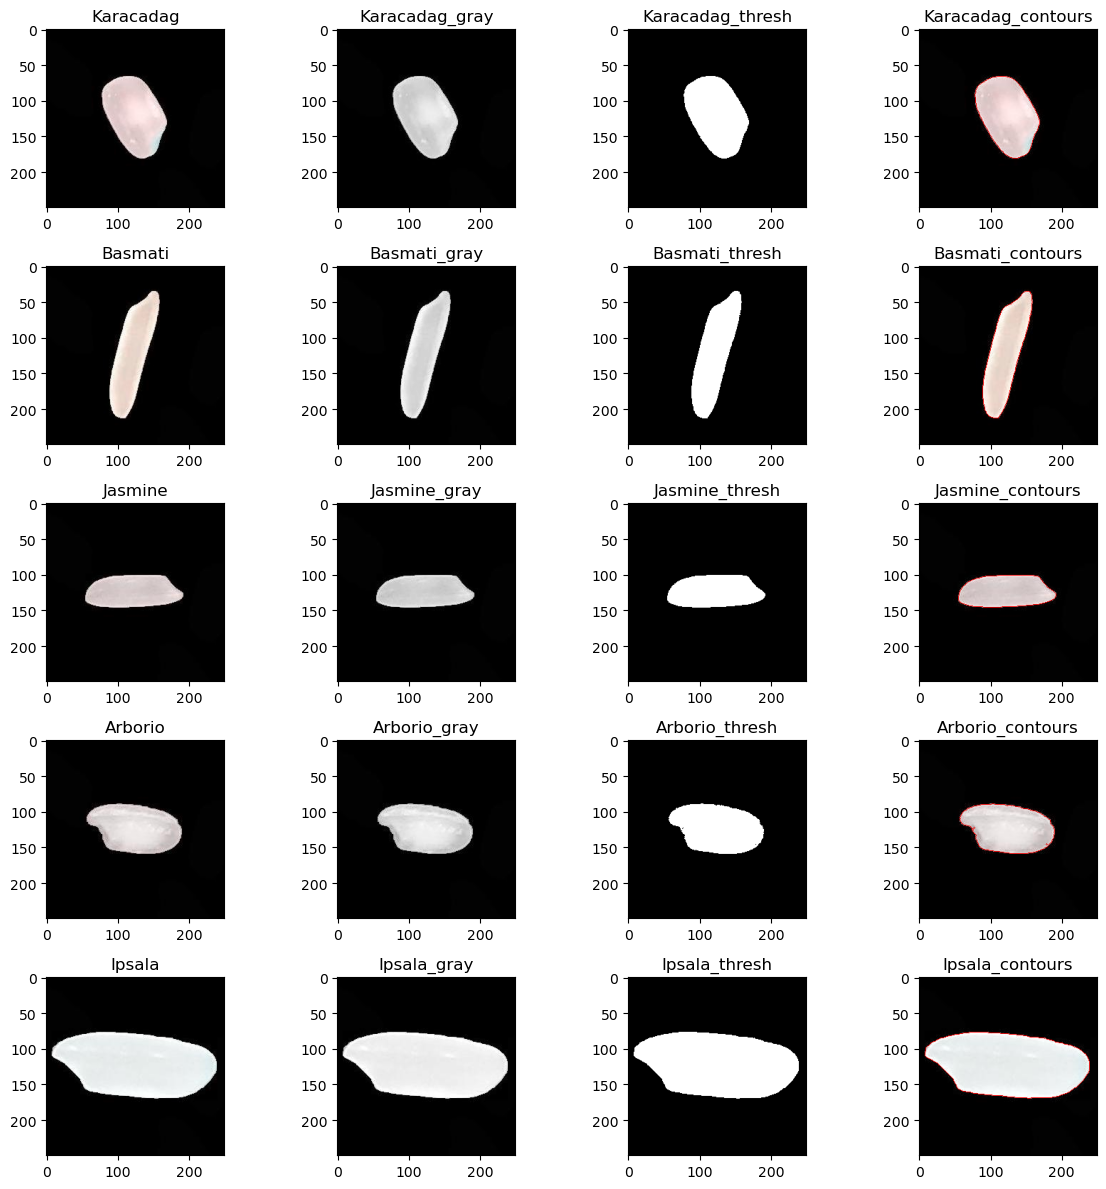

In [48]:
fig, axs = plt.subplots(nrows=5, ncols=num_sample_images*4, figsize=(12, 12))
for i, (k,v) in enumerate(image_dict.items()):
    for j, image_path in enumerate(v):
        img = cv2.imread(image_path)
        gray = to_grayscale(img)
        thresh = threshold_image(gray)
        title = k.split('/')[2]
        cnts, h = getContours(thresh)
        withConts = drawContours(img.copy(), cnts)
        
        axs[i,j].imshow(img)
        axs[i,j].set_title(title)
        
        axs[i,j+1].imshow(gray, cmap='gray')
        axs[i,j+1].set_title(title + "_gray")
        
        axs[i,j+2].imshow(thresh, cmap='gray')
        axs[i,j+2].set_title(title + "_thresh")
        
        axs[i,j+3].imshow(withConts)
        axs[i,j+3].set_title(title + "_contours")

plt.tight_layout();

## 4 Calculate features for all images

In [49]:
classes = list(image_dict.keys())

In [61]:
classwise_feature_dict = {}
classwise_img_dict = {}
error_images = []


for i, folder in enumerate(class_folders):
    img_class = folder.split("/")[-1].split()[0]
    array_lst = list()
    img_path_lst = list()
    
    for j, filename in enumerate(glob.glob(folder + "/*.jpg")):
        try:
            img = cv2.imread(filename)
            array_lst.append(calculateImageFeatures(getContours(threshold_image(to_grayscale(img).copy()).copy())[0], feature_cols))
            img_path_lst.append(filename)
        except Exception as err:
            error_images.append((img_class,filename))
            print(err)
            raise err
            break
    #print(len(array_lst))
    all_class_features = np.vstack(array_lst)
    classwise_feature_dict[img_class] = all_class_features
    classwise_img_dict[img_class] = img_path_lst
    print(f"Image Class: {img_class}")
    print(f"Total Images: {all_class_features.shape[0]}")
    print("--------------------------------------------")
    

Image Class: Karacadag
Total Images: 15000
--------------------------------------------
Image Class: Basmati
Total Images: 15000
--------------------------------------------
Image Class: Jasmine
Total Images: 15000
--------------------------------------------
Image Class: Arborio
Total Images: 15000
--------------------------------------------
Image Class: Ipsala
Total Images: 15000
--------------------------------------------


In [63]:
TOTAL_TRAIN_SAMPLES = 60000
TOTAL_TEST_SAMPLES = 15000

In [64]:
X_train, y_train = np.zeros((TOTAL_TRAIN_SAMPLES, len(feature_cols)), np.float32), np.zeros((TOTAL_TRAIN_SAMPLES, 1), np.float32)
X_test, y_test = np.zeros((TOTAL_TEST_SAMPLES, len(feature_cols)), np.float32), np.zeros((TOTAL_TEST_SAMPLES, 1), np.float32)
class_map = dict()

for i, (k, v) in enumerate(classwise_feature_dict.items()):
        class_map[i] = k
        X_train[i*12000:(i+1)*12000, :] = v[:12000, :]
        y_train[i*12000:(i+1)*12000, :] = i
        
        X_test[i*3000:(i+1)*3000] = v[12000:, :]
        y_test[i*3000:(i+1)*3000, :] = i


In [65]:
pprint.pprint(class_map)

{0: 'Karacadag', 1: 'Basmati', 2: 'Jasmine', 3: 'Arborio', 4: 'Ipsala'}


## Preprocessing Features

We will use a standard scaler for preprocessing our features

In [66]:
for i in range(X_train.shape[-1]):
    ss = StandardScaler()
    ss.fit(X_train[:, i].reshape((-1, 1)))
    X_train[:, i] = ss.transform(X_train[:, i].reshape((-1, 1))).flatten()
    X_test[:, i] = ss.transform(X_test[:, i].reshape((-1, 1))).flatten()

# 5 Classifying images

## Evaluating Multiple Models

We will use the following models for classification and use the best ones for feature evaluation using shap.

1. Logistic Regression
2. Support Vector Machine 
3. Random Forest Classifier
4. Multi Layer Perceptron

In [67]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [68]:
model_lst = [LogisticRegression(), LinearSVC(), RandomForestClassifier(), MLPClassifier()]

train_set_score = []
test_set_score = []
test_preds_all = []
for i, model in enumerate(model_lst):
    model.fit(X_train, y_train.ravel())
    train_set_score.append(model.score(X_train, y_train.ravel()))
    test_set_score.append(model.score(X_test, y_test.ravel()))
    test_preds = model.predict(X_test)
    test_preds_all.append(test_preds)
    
    print("-"*10+f"Classification Report for {type(model).__name__}"+"-"*10)
    print(classification_report(y_test, test_preds, target_names = [class_map[k] for k in class_map.keys()]))

C:\Users\ilan1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----------Classification Report for LogisticRegression----------
              precision    recall  f1-score   support

   Karacadag       0.95      0.95      0.95      3000
     Basmati       0.98      0.95      0.97      3000
     Jasmine       0.95      0.96      0.96      3000
     Arborio       0.92      0.95      0.93      3000
      Ipsala       1.00      0.99      1.00      3000

    accuracy                           0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000



C:\Users\ilan1\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


----------Classification Report for LinearSVC----------
              precision    recall  f1-score   support

   Karacadag       0.95      0.94      0.95      3000
     Basmati       0.98      0.97      0.98      3000
     Jasmine       0.94      0.96      0.95      3000
     Arborio       0.91      0.90      0.90      3000
      Ipsala       1.00      1.00      1.00      3000

    accuracy                           0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000

----------Classification Report for RandomForestClassifier----------
              precision    recall  f1-score   support

   Karacadag       0.96      0.94      0.95      3000
     Basmati       0.99      0.97      0.98      3000
     Jasmine       0.96      0.97      0.97      3000
     Arborio       0.91      0.95      0.93      3000
      Ipsala       1.00      0.99      1.00      3000

    accuracy                           0.96     15000
   mac

In [69]:
#all_accuracy_scores = [accuracy_score(y_test, i) for i in test_preds_all]
all_model_names = [type(i).__name__ for i in model_lst]

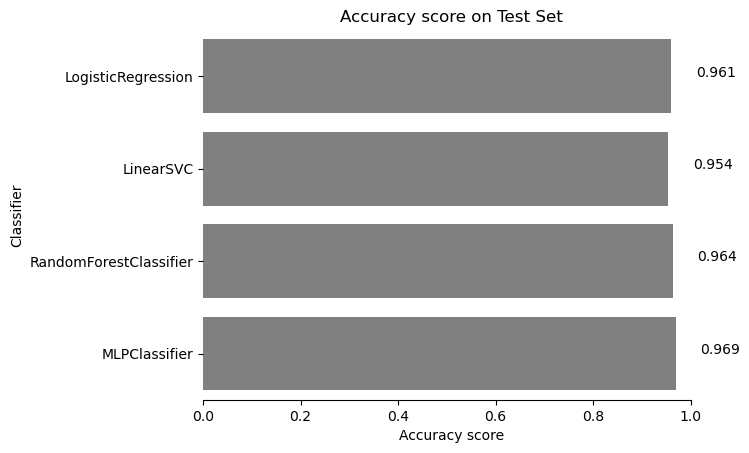

In [70]:
sns.barplot(x=test_set_score, y=list(range(len(model_lst))), orient='h', color='gray');
for i,s in enumerate(test_set_score):
    plt.text(s+0.05, i, "{:.3f}".format(s))
plt.yticks(ticks=range(len(model_lst)), labels=all_model_names);
plt.ylabel("Classifier");
plt.xlabel("Accuracy score");
plt.title("Accuracy score on Test Set");
sns.despine(trim=True, left=True);

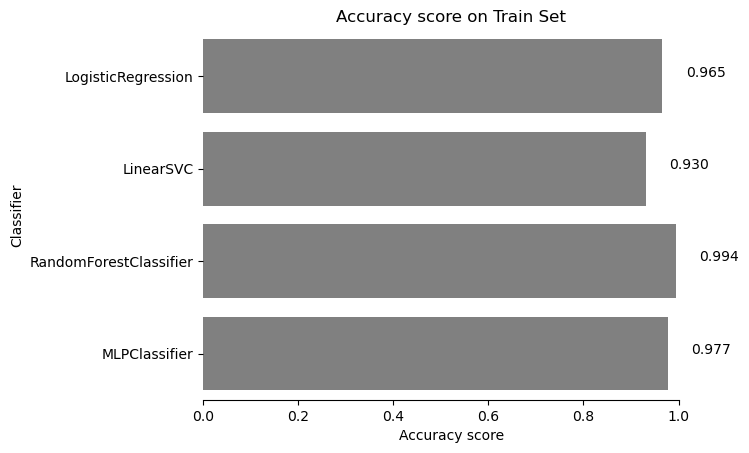

In [71]:
sns.barplot(x=train_set_score, y=list(range(len(model_lst))), orient='h', color='gray');
for i,s in enumerate(train_set_score):
    plt.text(s+0.05, i, "{:.3f}".format(s))
plt.yticks(ticks=range(len(model_lst)), labels=all_model_names);
plt.ylabel("Classifier");
plt.xlabel("Accuracy score");
plt.title("Accuracy score on Train Set");
sns.despine(trim=True, left=True);

{0: 'Karacadag', 1: 'Basmati', 2: 'Jasmine', 3: 'Arborio', 4: 'Ipsala'}


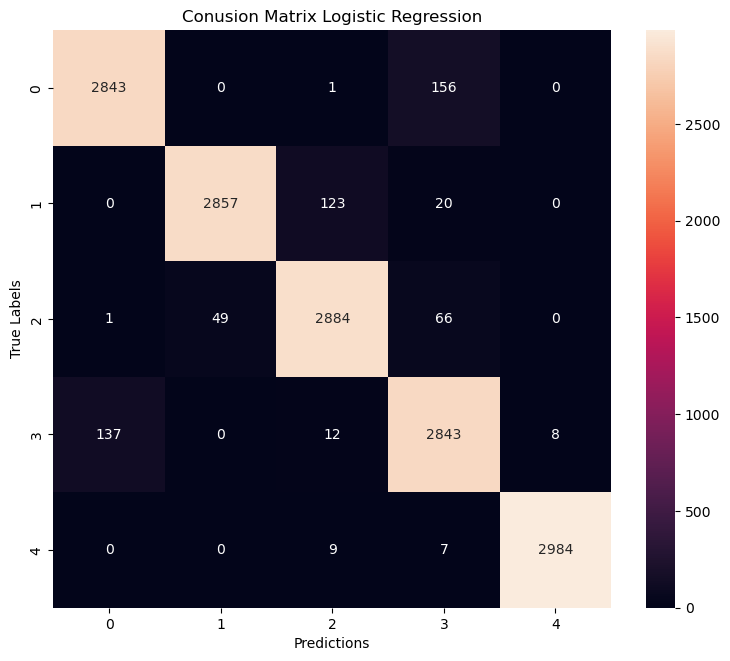

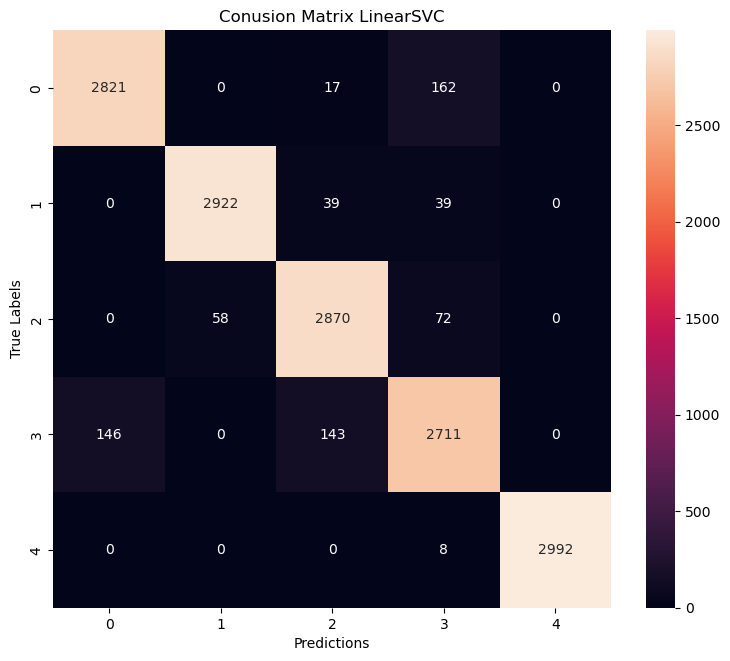

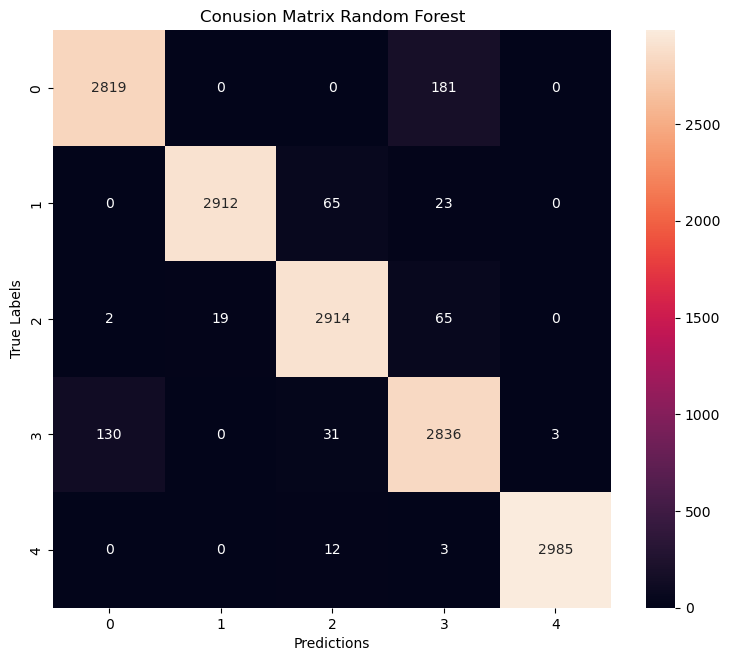

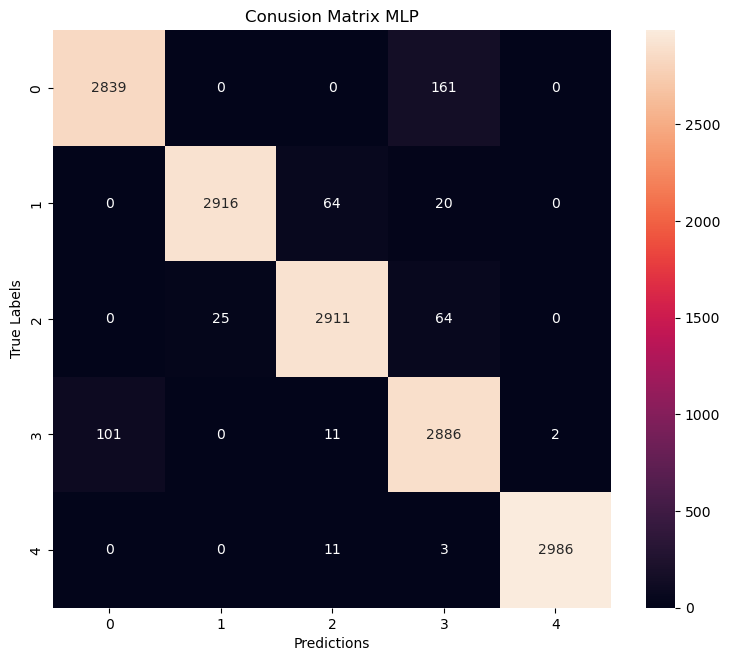

In [95]:
modelList = ['Logistic Regression', 'LinearSVC', 'Random Forest', 'MLP']
pprint.pprint(class_map)
for i in range(4):
    plt.figure(figsize = (9, 7.5), dpi = 100)
    sns.heatmap(metrics.confusion_matrix(y_test, test_preds_all[i]), annot = True, fmt='.0f')
    
    plt.xlabel('Predictions')
    plt.ylabel('True Labels')
    plt.title('Conusion Matrix ' + modelList[i])
    plt.show()

## 6 Feature analysis

Let's try to get insight on the important features for our two best classifiers - Random Forest and MLP

In [72]:
from sklearn.inspection import permutation_importance

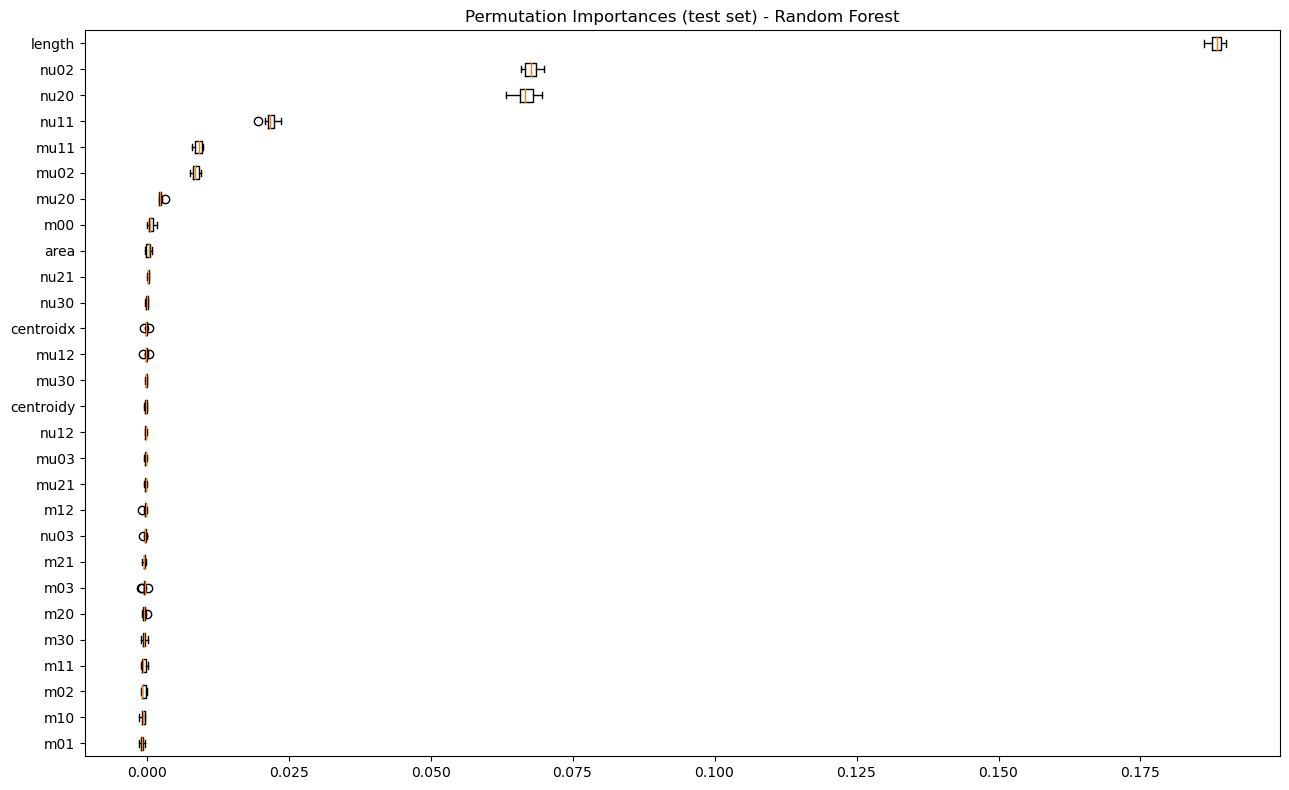

In [73]:
rfModel = model_lst[2]
result = permutation_importance(
    rfModel, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(13, 8))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=[feature_cols[i] for i in sorted_idx]
)
ax.set_title("Permutation Importances (test set) - Random Forest")
fig.tight_layout()
plt.show()

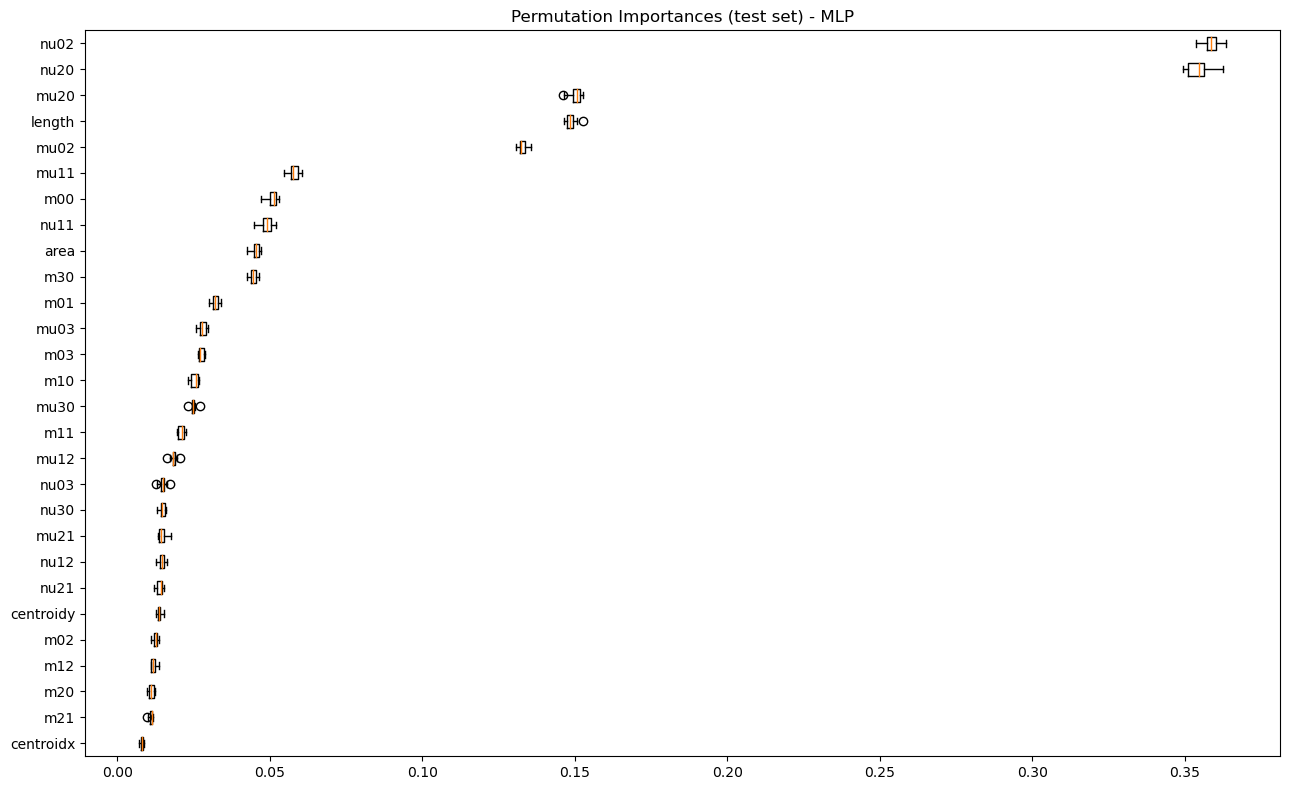

In [74]:
mlpModel = model_lst[-1]
result = permutation_importance(
    mlpModel, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(13, 8))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=[feature_cols[i] for i in sorted_idx]
)
ax.set_title("Permutation Importances (test set) - MLP")
fig.tight_layout()
plt.show()

## Answering our questions

1+5. For all of our ML models we reached more then 93% prediction accuracy. Where the SVM model was the lowest, while the Random Forest Classifier was the highest with 99.4% accuracy.
The MLP and the CNN models did quite good as well both around 98% accuracy.
Random Forest and MLP classifier perform best on both test and train set.
Logistic Regression Classifier is only slightly worse but perhaps can be improved through hyperparameter tuning.

2+4. The 2 types of rice that were the hardest to distinguish between them are "Arborio" and "Karacadag". The reason for that might be because they both have the same shape and size. The only difference might be is the size of the lattice in their shape.
In some models there was also mistakes distinguishing between "Jasmine" and "Basmati" rice but alot less then the 2 previously mentioned rice grains.

3+6. From the above plots, we can conclude that the second order invariant moments - "nu02" and "nu20" along with the length of the rice grain are significant for correct classification. Further, we can use the central and invariant moments to create more features like rotational invariants and try to improve the performance of our classifiers.